# **Twitter Sentiment Analysis Group Project**

## **Business Understanding**

### **Overview**

This project aims to build NLP models that can predict the sentiment of tweets for Apple and Google products as either positive, negative or neutral.

The NLP base model will be a binary classifier focusing on the positive and negative reviews and will expand into a multiclass classifier capturing neutral sentiment reviews.

This will aid the companies in collection of reviews for their products and build or improve said products from the reviews.

### **Business Problem and Stakeholders**


Marketing and Branding teams at technology companies such as Apple and Google rely heavily on public feedback to shape brand strategies. Social media platforms such as twitter provide a large source of customer feedback that is difficult to analyze manually due to the nature of tweets(text). The business problem for this project is the need for a system that can accurately classify the sentiment of tweets towards the products as positive, negative or neutral.  
By automatically identifying changes in public sentiments, marketing brands and teams can track brand perception and respond more quickly to customer feedback. The model will support data-driven branding decisions by transforming raw tweets into actionable sentiment insights.


### **Objectives**
#### **Main Objective**
Build a model that can rate the sentiment of a Tweet based on its content.
#### **Specific Objectives**
1. Develop an automated sentiment classification system that accurately labels tweets about Apple and Google products as positive, Negative or neutral.
2. Preprocess and transform raw Twitter text data into a structured format suitable for machine learning.
3. Train and evaluate multiple NLP models to identify the most effective approach for sentiment classification based on performance metrics such as accuracy, precision, recall, and F1-score.

## **Data Understanding**
The dataset being used is a set of tweets about Apple and Google products evaluated by some contributors. The crowd was asked if the tweet expressed positive, negative, or no emotion towards the brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion.  
This dataset contains 9093 data rows of tweets. It contains the tweets, the product/company and the sentiments.

In [25]:
# Import required libraries

# Data loading and manipulation
import pandas as pd
import numpy as np

# Text preprocessing and NLP
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk import FreqDist



# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


# Model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set(style="whitegrid")
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})


In [26]:
# Loading the data
df = pd.read_csv('./Data/judge-1377884607_tweet_product_company.csv',
    encoding='latin-1')

# Renaming columns
df.columns = ['tweet_text', 'product/company', 'sentiment']

# Displaying the first few rows of the dataframe
df.head()

,tweet_text,product/company,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [27]:
# Displaying dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_text       9092 non-null   object
 1   product/company  3291 non-null   object
 2   sentiment        9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


There are missing values in our data. The dataset has 9093 entries and 3 columns. All columns are string data types.

In [28]:
# Displaying the shape of the dataframe
df.shape

(9093, 3)

In [29]:
# Displaying sentiment value counts
df['sentiment'] .value_counts()

sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

This displays class imbalance in the sentiment class.

In [30]:
# Displaying product/company value counts
df['product/company'].value_counts()

product/company
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [31]:
# Displaying statistical summary of the dataframe
df.describe()

,tweet_text,product/company,sentiment
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


## **Data Cleaning and Preprocessing**

### **Data Cleaning**

In [32]:
# Creating a copy of the dataframe for cleaning
clean_df = df.copy()

In [33]:
# Checking for duplicate rows in the dataframe
clean_df.duplicated().sum()

np.int64(22)

In [34]:
# Removing duplicate rows from the dataframe
clean_df = clean_df.drop_duplicates()
clean_df.duplicated().sum()

np.int64(0)

In [35]:
# Checking for null values in the dataframe
clean_df.isnull().sum()

tweet_text            1
product/company    5789
sentiment             0
dtype: int64

In [36]:
# Removing rows with null values in 'tweet_text' column
clean_df = clean_df.dropna(subset=['tweet_text'])

The product/company column has a lot of missing values which would bring bias to the model if they were filled with the mode of the column, thus we drop the column.

In [37]:
# Removing the product/company column due to the high missing values
clean_df = clean_df[['tweet_text', 'sentiment']]

In [38]:
# Confirming the non existence of null values
clean_df.isnull().sum()

tweet_text    0
sentiment     0
dtype: int64

In [39]:
# Displaying the values of the sentiment column
clean_df['sentiment'].value_counts()

sentiment
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64

In [40]:
# Map sentiment labels
clean_df['sentiment'] = clean_df['sentiment'].map({
    'Positive emotion': 'positive',
    'Negative emotion': 'negative',
    'No emotion toward brand or product': 'neutral',
    "I can't tell": 'uncertain'
})

The uncertain values are removed in order to reduce noise and stick to the three sentiment values.

In [41]:
# Removing rows with 'uncertain' sentiment
clean_df = clean_df[clean_df['sentiment'] != "uncertain"].reset_index(drop=True)

In [42]:
# Confirmation of sentiment value counts after removal of uncertain values and label changes
clean_df['sentiment'].value_counts()

sentiment
neutral     5375
positive    2970
negative     569
Name: count, dtype: int64

In [43]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914 entries, 0 to 8913
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  8914 non-null   object
 1   sentiment   8914 non-null   object
dtypes: object(2)
memory usage: 139.4+ KB


In [44]:
# Text cleaning
def clean_text(text):
    text = text.lower() # Converting to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text) # Removing URLs
    text = re.sub(r'@\w+','', text) # Removing mentions
    text = re.sub(r'#\w+', '', text) # Removing hashtags 
    text = re.sub(r'[^A-Za-z\s]', '', text) # Removing special characters and numbers(Punctuations, emojis)
    return text

clean_df['clean_text'] = clean_df['tweet_text'].apply(clean_text)
clean_df.head()


,tweet_text,sentiment,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative,i have a g iphone after hrs tweeting at it ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,positive,know about awesome ipadiphone app that youl...
2,@swonderlin Can not wait for #iPad 2 also. The...,positive,can not wait for also they should sale them...
3,@sxsw I hope this year's festival isn't as cra...,negative,i hope this years festival isnt as crashy as ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,positive,great stuff on fri marissa mayer google tim ...


### **Data Preprocessing**

In [45]:
basic_token_pattern = r"[a-zA-Z]+(?:'[a-z]+)?" # Token pattern to split text into words
tokenizer = RegexpTokenizer(basic_token_pattern) # Tokenizer using the defined pattern
stopwords_list = stopwords.words('english') # Set of English stopwords
lemmatizer = WordNetLemmatizer() # lemmatizer for reducing words to their base


In [46]:
prepocessed_tweets = []
for tweet in clean_df['clean_text']:
    tokens = tokenizer.tokenize(tweet)
    stopped_tokens = [word for word in tokens if word not in stopwords_list] # Removing stopwords
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stopped_tokens] # Lemmatization
    prepocessed_tweets.append(' '.join(lemmatized_tokens)) # Joining tokens back to string
clean_df['preprocessed_tweet'] = prepocessed_tweets
clean_df.head()


,tweet_text,sentiment,clean_text,preprocessed_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative,i have a g iphone after hrs tweeting at it ...,g iphone hr tweeting dead need upgrade plugin ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,positive,know about awesome ipadiphone app that youl...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,positive,can not wait for also they should sale them...,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,negative,i hope this years festival isnt as crashy as ...,hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,positive,great stuff on fri marissa mayer google tim ...,great stuff fri marissa mayer google tim oreil...


## **Exploratory Data Analysis**

### Bar Graph of Sentiment Distribution 

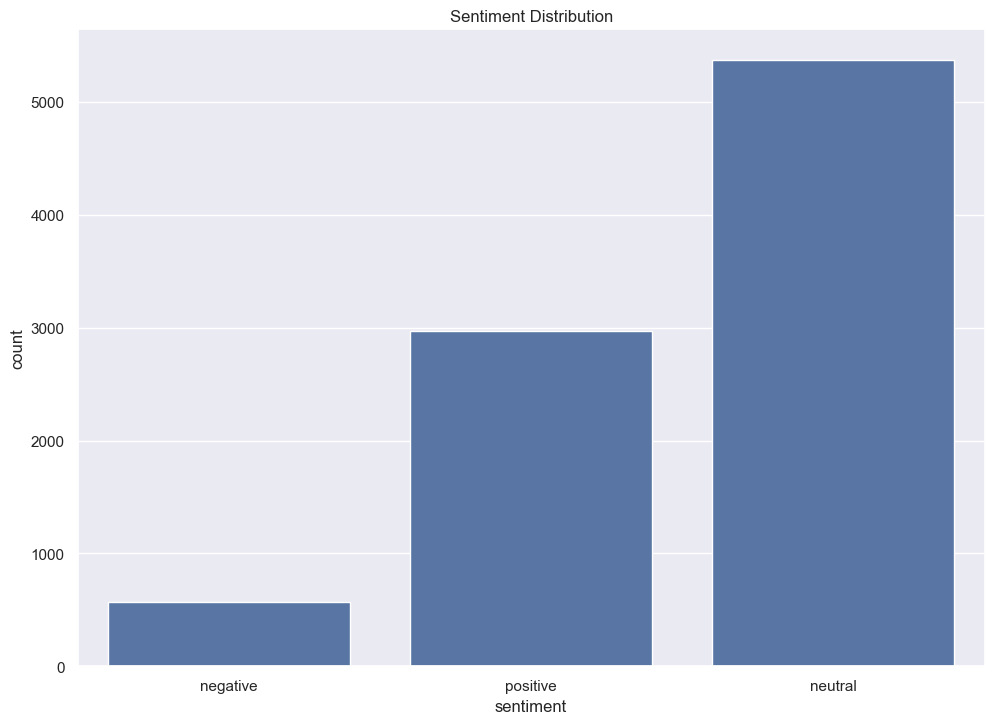

In [47]:
sns.countplot(x='sentiment', data=clean_df)
plt.title("Sentiment Distribution")
plt.show()

### Wordclouds of The Different Classes

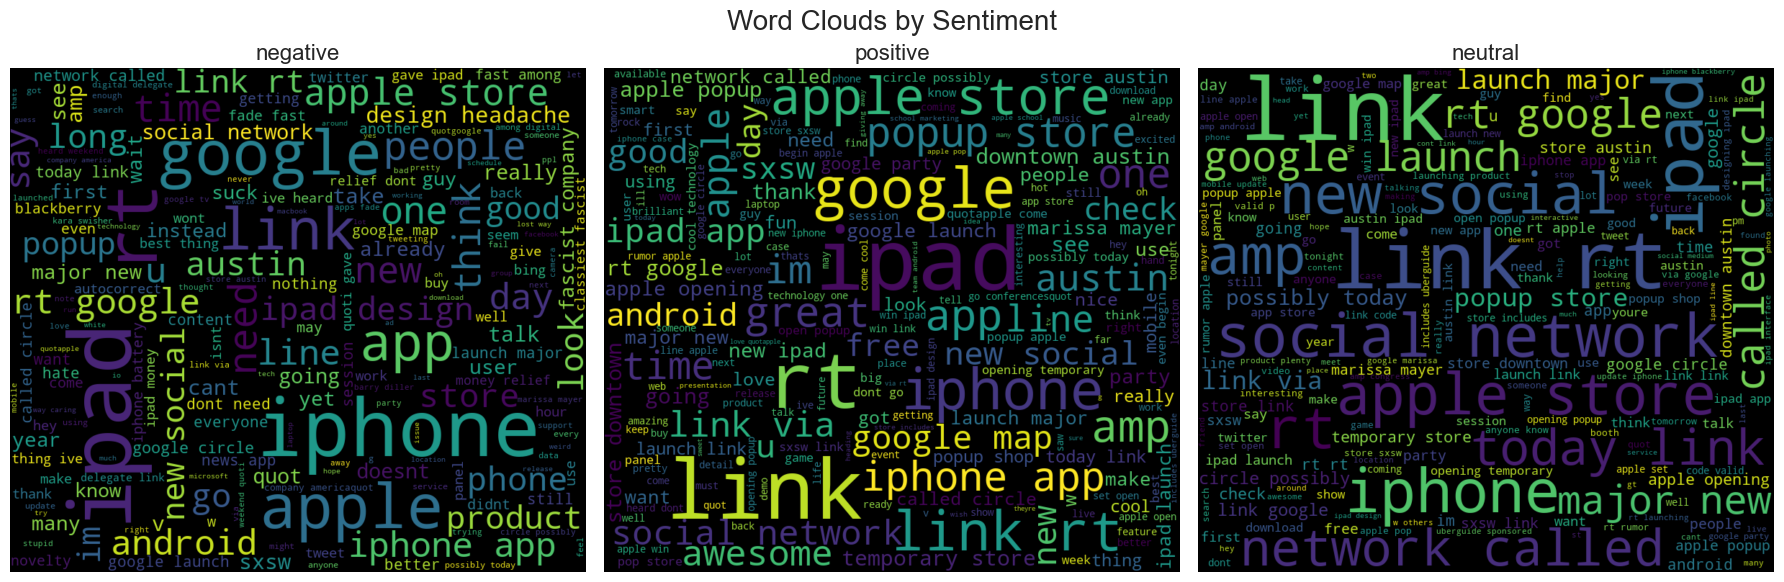

In [48]:
# Ensuring each tweet is a list of words
clean_df['tokens'] = clean_df['preprocessed_tweet'].apply(lambda x: x.split())

# Getting the unique sentiment labels
sentiment_labels = clean_df['sentiment'].unique()
# Create 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18,6))
fig.set_tight_layout(True)

# Generate WordCloud for each sentiment
for idx, sentiment in enumerate(sentiment_labels):
    # Combine all words into a single string
    all_words = ' '.join(
        word for tokens in clean_df[clean_df['sentiment'] == sentiment]['tokens'] for word in tokens
    )
    
    # Create WordCloud
    wordcloud = WordCloud(width=800,height=700,max_font_size=120).generate(all_words)
    
    # Plot in the corresponding subplot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(sentiment, fontsize=16)

fig.suptitle("Word Clouds by Sentiment", fontsize=20)
plt.show()


## **Modeling and Evaluation**

In [49]:
# Preparing data for modeling
modeling_df = clean_df[['preprocessed_tweet','sentiment']]
modeling_df.head(2)

,preprocessed_tweet,sentiment
0,g iphone hr tweeting dead need upgrade plugin ...,negative
1,know awesome ipadiphone app youll likely appre...,positive


### **Binary Classification (Positive and Negative Sentiments)**

In [50]:
# Creating a binary classification dataframe using the positive and negative classes
binary_df = modeling_df[modeling_df['sentiment'].isin(['positive', 'negative'])]
binary_df.head()

,preprocessed_tweet,sentiment
0,g iphone hr tweeting dead need upgrade plugin ...,negative
1,know awesome ipadiphone app youll likely appre...,positive
2,wait also sale,positive
3,hope year festival isnt crashy year iphone app,negative
4,great stuff fri marissa mayer google tim oreil...,positive


In [51]:
binary_df['sentiment'].value_counts()

sentiment
positive    2970
negative     569
Name: count, dtype: int64

In [52]:
binary_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3539 entries, 0 to 8909
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   preprocessed_tweet  3539 non-null   object
 1   sentiment           3539 non-null   object
dtypes: object(2)
memory usage: 82.9+ KB


In [53]:
# Counting total number of tokens in the preprocessed tweets
token_count = binary_df['preprocessed_tweet'].apply(lambda x: len(x.split())).sum()
token_count

np.int64(34517)

In [54]:
# Splitting the binary dataframe into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(binary_df['preprocessed_tweet'],binary_df['sentiment'], test_size=0.3, random_state=42, stratify=binary_df['sentiment'])
X_train

8100      client android gotten really buggy lately blame
8363    mobile activation month android taking huge ma...
3409    hey yall anyway get text update dont cool pock...
1979    day bank america launched iphone app got k new...
4336    rt google launch major new social network call...
                              ...                        
4627    thinking shoulda gone sxsw year first year ipa...
2021    temp apple storegreat move really need help br...
969     hey new ipad app dexteria available link like ...
7054          twitter failed last time force choke iphone
4794          mine toooo rt envy roof thanks every person
Name: preprocessed_tweet, Length: 2477, dtype: object

In [55]:
# Encoding the target labels
le = LabelEncoder() 
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

The number of max_features is considered from the number of tokens which is 34,517.

15% of the total number of tokens was considered, which is approximately 5,000.

In [56]:
# Vectorization using TF-IDF
tfidf = TfidfVectorizer(max_features=5000) 
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

In [57]:
# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vectorized, y_train)

In [58]:
# Building and evaluating our baseline Logistic Regression model
binary_baseline_model = LogisticRegression(random_state=42,class_weight='balanced')
binary_baseline_model.fit(X_train_res, y_train_res)
y_logreg_pred = binary_baseline_model.predict(X_test_vectorized)
print('Accuracy score on test set:', accuracy_score(y_test, y_logreg_pred))

Accuracy score on test set: 0.8502824858757062


In [59]:
# Building and evaluating our Random Forest Classifier model
binary_rf_model = RandomForestClassifier(random_state=42,class_weight='balanced')
binary_rf_model.fit(X_train_res, y_train_res)
y_rf_pred = binary_rf_model.predict(X_test_vectorized)
print('Accuracy score on test set:', accuracy_score(y_test, y_rf_pred))


Accuracy score on test set: 0.871939736346516


In [60]:
# Building and evaluating our Naive Bayes model
binary_nb_model = MultinomialNB()
binary_nb_model.fit(X_train_res, y_train_res)
y_nb_pred = binary_nb_model.predict(X_test_vectorized)
print('Accuracy score on test set:', accuracy_score(y_test, y_nb_pred))

Accuracy score on test set: 0.8239171374764596


In [61]:
# Building and evaluating our Linear SVC model
binary_linearsvc_model = LinearSVC(random_state=42,class_weight='balanced')
binary_linearsvc_model.fit(X_train_res, y_train_res)
y_linearsvc_pred = binary_linearsvc_model.predict(X_test_vectorized)
print('Accuracy score on test set:', accuracy_score(y_test, y_linearsvc_pred))

Accuracy score on test set: 0.8625235404896422


In [62]:
# Creating a function to evaluate models
def evaluate_model(model_name, y_true, y_pred):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }


In [63]:
# Evaluating all binary classification models and storing results in a dataframe
binary_results = []
binary_results.append(evaluate_model("Binary Logistic Model", y_test, y_logreg_pred))
binary_results.append(evaluate_model("Binary Random Forest", y_test, y_rf_pred))
binary_results.append(evaluate_model("Binary Multinomial Naive Bayes", y_test, y_nb_pred))
binary_results.append(evaluate_model("Binary Linear SVC", y_test, y_linearsvc_pred))
binary_results_df = pd.DataFrame(binary_results)
binary_results_df

,Model,Accuracy,Recall,Precision,F1 Score
0,Binary Logistic Model,0.850282,0.900112,0.919725,0.909813
1,Binary Random Forest,0.871940,0.985410,0.877123,0.928118
2,Binary Multinomial Naive Bayes,0.823917,0.855219,0.929268,0.890707
3,Binary Linear SVC,0.862524,0.932660,0.906216,0.919248


The best model for binary (positve,negative ) is a random forest with an accuracy of 87%

### **Multiclassifier Modelling(Positive, Negative, Neutral)**

In [ ]:
# Creating a multi-class classification dataframe using positive, negative, and neutral classes
multi_df = modeling_df[modeling_df['sentiment'].isin(['positive','negative','neutral'])]

multi_df.head()

,preprocessed_tweet,sentiment
0,g iphone hr tweeting dead need upgrade plugin ...,negative
1,know awesome ipadiphone app youll likely appre...,positive
2,wait also sale,positive
3,hope year festival isnt crashy year iphone app,negative
4,great stuff fri marissa mayer google tim oreil...,positive


In [65]:
multi_df['sentiment'].value_counts()

sentiment
neutral     5375
positive    2970
negative     569
Name: count, dtype: int64

In [ ]:
# Displaying multi-class dataframe information
multi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914 entries, 0 to 8913
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   preprocessed_tweet  8914 non-null   object
 1   sentiment           8914 non-null   object
dtypes: object(2)
memory usage: 139.4+ KB


In [ ]:
# Counting total number of tokens in the multi-class preprocessed tweets
multi_token_count = multi_df['preprocessed_tweet'].apply(lambda x: len(x.split())).sum()
multi_token_count

np.int64(84972)

The token count for the multiclassifier is 84,972 therefore we used 15% of that value which is approximately 12,500

In [ ]:
# Splitting the multi-class dataframe into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    multi_df['preprocessed_tweet'], multi_df['sentiment'],
    test_size=0.3, random_state=42, stratify=multi_df['sentiment']
)
# Encoding the target labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# Vectorization using TF-IDF
tfidf = TfidfVectorizer(max_features=12500)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

mote = SMOTE(random_state=42)
X_train_res2, y_train_res2 = smote.fit_resample(X_train_vec, y_train)



In [ ]:
# Train multiclass models
multi_models = {
    "Logistic Regression": LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Naive Bayes": MultinomialNB(),
    "Linear SVC": LinearSVC(class_weight='balanced')
}



for name, model in multi_models.items():
    model.fit(X_train_res2, y_train_res2)
    y_pred = model.predict(X_test_vec)



Logistic Regression

              precision    recall  f1-score   support

    negative       0.30      0.53      0.38       171
     neutral       0.76      0.67      0.71      1613
    positive       0.55      0.60      0.57       891

    accuracy                           0.63      2675
   macro avg       0.54      0.60      0.56      2675
weighted avg       0.66      0.63      0.64      2675


Random Forest

              precision    recall  f1-score   support

    negative       0.62      0.18      0.27       171
     neutral       0.69      0.85      0.76      1613
    positive       0.60      0.44      0.51       891

    accuracy                           0.67      2675
   macro avg       0.64      0.49      0.51      2675
weighted avg       0.66      0.67      0.64      2675


Naive Bayes

              precision    recall  f1-score   support

    negative       1.00      0.02      0.03       171
     neutral       0.65      0.95      0.77      1613
    positive       0.69

In [ ]:
# Creating a function to evaluate models
def evaluate_model(model_name, y_true, y_pred):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "F1 Score": f1_score(y_true, y_pred, average='weighted')}

In [ ]:
# Evaluating all multi-class classification models and storing results in a dataframe
multi_results = []
for name, model in multi_models.items():
    y_pred = model.predict(X_test_vec)
    multi_results.append(evaluate_model(name, y_test, y_pred))
multi_results_df = pd.DataFrame(multi_results)
multi_results_df    

,Model,Accuracy,Recall,Precision,F1 Score
0,Logistic Regression,0.634019,0.634019,0.661876,0.643733
1,Random Forest,0.667290,0.667290,0.656133,0.644651
2,Naive Bayes,0.654953,0.654953,0.684605,0.588561
3,Linear SVC,0.663551,0.663551,0.663660,0.663463


The best model for multiclass(positve,negative and neutral) is a random forest with an accuracy of 67%.

## **Recommendations**
1. We built a binary classifier for positive and negative sentiment. We recommend deploying this model in marketing and branding systems for twitter feedback analysis.
2. The multi classifier has an accuracy of 67% which is a bit low due to unclear classification of the neutral sentiment. We recommend finding better strategies for training this model in the future.
3. Classification was done using the tweet itself. Incorporating additional features such as emojis, hashtags and user engagement metrics (like, retweets) would improve sentiment classification performance.

## **Conclusion**
This project successfully addressed the tasked of sentiment analysis by building and evaluating machine learning models for both binary and multi class sentiment classification.

Through effective data preprocessing, feature extraction and model evaluation, the approach was able to accurately identify sentiment patterns within twitter texts.

This analysis helps organisations understand public opinion and customer feedback, enabling data-driven decisions that improve brand engagement and strategic planning.